# C-mean Clustering
Fuzzy c-Means Clustering} (FMC) is a clustering method which, unlike Hard k-Means Clustering, allows a data sample to more or less belong to one or more clusters. In this notebook, we will try to develop a semi-supervised C-mean Clustering.

## Loading the packages

In [1]:
import numpy as np
from cvi import * # fcm
import matplotlib.pyplot as plt
from numpy import genfromtxt
from random import randint
import operator
import math
from sklearn import metrics
import scipy.spatial
import copy
DATASETS = ['melanomaTest.dat.txt', 'BreastCancerData.txt'] # http://cibcb.org/data/

PATH_TO_DATASET = DATASETS[0] # Not Given Yet 

%matplotlib inline

## The dataset
Here we load the dataset and delete randomly some labels to test our implementation of semi-supervised FCM

In [2]:
dataset = genfromtxt(PATH_TO_DATASET, delimiter=' ')

# format the dataset 
for i in range(len(dataset)):
    dataset[i][-1] = 2 if dataset[i][-1] == 1 else 1
    
# save all the labels to calculate the performance of our algorithm
true_labels = copy.copy(dataset[:, -1])

# remove some labels for test purpose
for i in range(50):
    dataset[randint(0, len(dataset) - 1)][-1] = 0

## FCM algorithm
Here we define a unsupervised implementation of the FCM from ...

In [3]:
def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

def fcm(x, c, m=2.0, v=None, max_iter=100, error=0.05):
    if v is None: v = x[np.random.randint(x.shape[0], size=c)]
    u = fcm_get_u(x, v, m)
    for iteration in range(max_iter):
        u_old = u
        um = u**m
        v = np.dot(um, x)/np.sum(um, axis=1, keepdims=True)
        u = fcm_get_u(x, v, m)
        if np.linalg.norm(u - u_old) < error: break
    return u, v

## Semi-supervised C-Mean
Here are all the function needed to transform our algorithm to a semi-supervised one

In [4]:
def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = np.array(u).shape
    d = np.array(v).shape[1]
    
    um = np.array(u)**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])
    
    return covariances

# Partition Coefficient
def pc(x, u, v, m):
    c, n = np.array(u).shape
    return np.square(np.array(u)).sum()/n

# Fuzzy Hyperbolic Volume
def fhv(x, u, v, m):
    covariances = calculate_covariances(x, u, v, m)
    return sum(np.sqrt(np.linalg.det(cov)) for cov in covariances)

# Xie-Beni Index
def xb(x, u, v, m):
    n = np.array(x).shape[0]
    c = np.array(v).shape[0]

    um = np.array(u)**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def checkKnownEntries(dataset, labels, c):
    res = np.zeros((c, 2))
    for cluster in range(c) :
        for i in range(len(dataset)):
            if(dataset[i][-1] != 0 and labels[i] == cluster):
                res[cluster][int(dataset[i][-1] - 1)] += 1
    
    for cluster in range(c):
        c_total = res[cluster][0] + res[cluster][1]
        res[cluster][0] /= c_total
        res[cluster][1] /= c_total

    return res

In [5]:
def getClass(dataset, labels, k):
    count_class = np.zeros((k, 2))
    newLabels = copy.copy(labels)

    for i in range(len(dataset)):
        if(dataset[i][-1] != 0):
            count_class[labels[i]][int(dataset[i][-1] - 1)] += 1

    for c in range(len(count_class)):     
        if count_class[c][0] < count_class[c][1]:
            cl = 2 
        elif count_class[c][0] > count_class[c][1]:
            cl = 1 
        else :
            cl = 0
            
        for i in range(len(labels)):
            if labels[i] == c:
                newLabels[i] = cl 
            
    return newLabels
    

In [6]:
def getAccuracy(true_labels, labels):
    same = 0
    for t, p in zip(true_labels, labels):
        if int(t) == int(p):
            same += 1
    return same / len(true_labels) * 100

In [7]:
def getClusters(dataset, membership_mat):
    cluster_labels = list()
    for i in range(len(dataset)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

## Main Execution 
blablabla

In [8]:
def clusterize(dataset):
    result_labels = [[]]
    result_mb     = [[]]
    temp_data = copy.deepcopy(dataset)
    c = 2
    done = False
    while(not done and c < math.sqrt(len(dataset))): 
        mb, centers = fcm(dataset[:,:-1], c)
        labels = getClusters(dataset[:,:-1], mb.T )
        
        # First, check supervised values
        # TOFIX : Bordel with cluster indexes, won't work.
        sup_verif = checkKnownEntries(dataset, labels, c)
        cluster_ok = []
        for i in range(c):
            if(sup_verif[i][0] < 0.2 or sup_verif[i][0] > 0.8):
                cluster_ok.append(i)

        if(len(cluster_ok) < c):
            # If no cluster is good enough (with known values) start with more clusters
            c =c + 1
            continue
        else:
            # Check our values aren't just luckily in same clusters using unsup CVI
            #fhv_s = fhv(x = temp_data[:,:-1], v = centers, u = mb, m =2)
            #pc_s  = pc(temp_data[:,:-1], mb, centers, 2)
            #xb_s  = xb(x = temp_data[:,:-1], u = mb, v = centers, m = 2)
            # If values aren't good enough, our know entries were "luckily" grouped
            #if(pc_s < 0.9 or xb_s > 0.1):#fhv_s > 0.1 or 
            #    c = c + 1
            #    continue
            #else:
            done = True
            break
            # Else, we have to keep labeled data and remove it  
            temp_data = [[]]
            for i in range(len(dataset)):
                if(dataset[i][-1] in cluster_ok):
                    result_labels.append(dataset[i].append(labels[i]))
                    result_mb.append(mb[i])
                else:
                    temp_data.append(dataset[i])
                    
            # Keep same number of pixels (equivalent to split remaining clusters in +1)
            continue
            
    return labels, centers, mb

labels, centers, mb = clusterize(dataset)
labels = getClass(dataset, labels, len(centers))
print("label:", labels, len(labels))
print("true_label:",true_labels, len(dataset[:,-1]) )
print("number of cluster = ", len(centers))
print("accuracy = ", getAccuracy(true_labels, labels))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


label: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## Results and Analyse

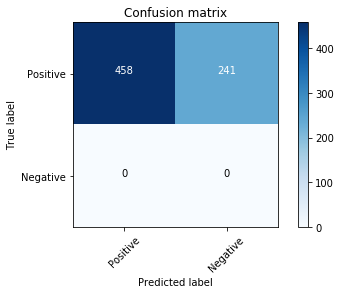

In [9]:
from sklearn.metrics import confusion_matrix
import itertools
conf_mat = metrics.confusion_matrix(labels, true_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    labels_names = ["Positive", "Negative"]
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

In [10]:
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)


Precision:  0.5
Recall:  nan
F1-Score:  nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
